## Imports

In [1]:
import sys
import os
import numpy as np
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
root = "/Users/phdenzel/gleam"
sys.path.append(root)
import gleam
from gleam.lensobject import LensObject
from gleam.utils.lensing import LensModel
from gleam.reconsrc import ReconSrc, run_model
from gleam.utils.pdfs import lorentzian, gaussian, pseudovoigt, tukeygh
from gleam.utils.pdfs import Measure
from gleam.utils.plotting import kappa_map_plot, kappa_profiles_plot
from gleam.utils.plotting import arrival_time_surface_plot
from gleam.utils.plotting import plot_scalebar, plot_labelbox
from gleam.utils.rgb_map import radial_mask
from gleam.utils.units import H02aHz, aHz2H0, H02Gyrs, H02critdens
import gleam.utils.colors as gcl
gcl.GLEAMcmaps.register_all()


## Load data

In [2]:
#        ACS          ACS(WFC3)        ACS(WFC3)      WFC3(UNK)
#        WFC3         SBC              WFC3           ACS(GAIA)
objs = ['B1608+656', 'DESJ0408-5354', 'HE0435-1223', 'PG1115+080',
        'RXJ0911+0551', 'RXJ1131-1231', 'SDSSJ1004+4112', 'WFIJ2033-4723']
objidx = 0
sigf = 20     #   80(20),  100(25),   60(12),  600(60),  140(35), 4000 (50),   80,   80
lens = objs[objidx]
print(lens)


B1608+656


In [3]:
fitsdir = 'data/delay_qsos/'
fitsfile = fitsdir + '{}.fits'.format(lens)
print(fitsfile)

jsondir = 'jsons/'
jsonfile = jsondir + '{}.json'.format(lens)
print(jsonfile)


data/delay_qsos/B1608+656.fits
jsons/B1608+656.json


In [4]:
with open(jsonfile) as f:
    lo = LensObject.from_json(f)
lo.squarify(0)   # 0, 0, 0, 0, 0
print(lo.__v__)


Properties of that field are unknown [None]
filename            	B1608+656.json
filepath            	/Users/phdenzel/delays/jsons/B1608+656.json
band                	
naxis1              	99
naxis2              	99
naxis_plus          	None
refval              	[242.30025957375, 65.541446346654]
refpx               	[69.5, -175.5]
center              	<242.3009, 65.5446>
px2deg              	[1.388888888888882e-05, 1.388888888888882e-05]
px2arcsec           	[0.04999999999999975, 0.04999999999999975]
megacam_range       	None
field               	None
photzp              	None
mag_formula         	<function mag_formula at 0x7fceacbe1500>
roi                 	ROISelector(99, 99)
lens                	None
srcimgs             	[]
zl                  	0.63
zs                  	1.39
mapr                	2.475
tdelay              	None
tderr               	None
light_model         	{}
stel_mass           	None
glscfactory         	GLSCFactory(zl, srcimgs, parity, tderr...)
finder            

In [5]:
statedir = 'states/'
statefiles = ['11doubles_dg45.state',
              '11doubles_dg60.state', '11doubles_CMB_dg60.state', '11doubles_SNeIa_dg60.state',
              '7quads_dg45.state', '7quads_CMB_dg45.state', '7quads_SNeIa_dg45.state',
              '7quads_dg60.state', '7quads_CMB_dg60.state', '7quads_SNeIa_dg60.state', 
              'all_dg60.state', 'all_SNeIa_dg60.state']
statefile = statefiles[7]  # 7  8/9 5/6
print(statefile)


7quads_dg60.state


In [6]:
lm = LensModel(statedir+statefile)
lm.obj_idx = objidx
print(lm.__v__)


filename            	7quads_dg60.state
filepath            	states/7quads_dg60.state
N                   	1000
pixrad              	8
maprad              	1.84670387036
pixel_size          	0.0434518557732
kappa               	None
minima              	[[-0.8215179170393514   1.2798384391770945 ]
 [ 1.0982397417262912   0.42373029405187596]]
saddle_points       	[[ 0.6745094476744152   1.2020104259838928 ]
 [-0.22483648255813793 -0.6399192195885473 ]]
maxima              	[]
zl                  	0.63
zs                  	1.39
N_obj               	8
N_src               	1
obj_idx             	0
src_idx             	0


In [7]:
# %%script false
qs = np.loadtxt("results/filters/7quads_dg60_B1608+656_chi2.txt")
# qs = np.loadtxt("results/filters/7quads_dg60_DESJ0408-5354_chi2.txt")
print(len(qs))


1000


In [8]:
iqs = np.argsort(qs)
iq = iqs[0]
print iq, qs[iq]

809 1.2325791319533947


In [9]:
planck = Measure(name="Planck", mean=67.4, std=0.5)  # arxiv.org/abs/1807.06209
shoes = Measure(name="SH0ES", mean=74.03, std=1.42)  # arxiv.org/abs/1903.07603
cchp = Measure(name="CCHP", mean=69.8, std=1.7)  # arxiv.org/abs/1907.05922
print(planck())


([66.9, 67.4, 67.9], [0, 0, 0])


In [10]:
H0data = np.array(lm.H0)
H0data = H0data[iqs[:300]]  # best 30%

aHzH0 = H02aHz(H0data)
invH0 = H02Gyrs(H0data)
rhocrit = H02critdens(H0data)
print(aHzH0[0])
print(invH0[0])
print(rhocrit[0])


2.460696855311345
12.935761895933169
6.07467310038713


(2.327364655370396, 0.1251111160156797, -0.10612860233800747)
(71.81496941031818, 3.8605256588494967, -3.2747864898940264)
H$_0$ = $ 71.8^{+3.9}_{-3.3}$


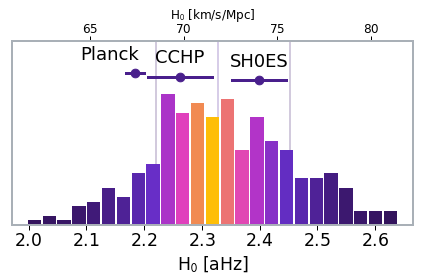

In [16]:
q = np.percentile(aHzH0, [16, 50, 84])
print(q[1], np.diff(q)[1], -np.diff(q)[0])
fig, ax = plt.subplots()
axc = ax.twiny()
# second unit axis
def convertaxc(ax):
    x1, x2 = ax.get_xlim()
    axc.set_xlim(aHz2H0(x1), aHz2H0(x2))
    axc.figure.canvas.draw()
ax.callbacks.connect("xlim_changed", convertaxc)

nbins = 25
n, bins, patches = ax.hist(aHzH0, bins=nbins, density=True, rwidth=0.901)
cm = plt.cm.get_cmap('phoenix')
ax.axvline(q[1], color=cm(0.20), alpha=0.3, zorder=0)
ax.axvline(q[0], color=cm(0.05), alpha=0.3, zorder=0)
ax.axvline(q[2], color=cm(0.05), alpha=0.3, zorder=0)
yl = ax.get_ylim()

# add gaussian/lorentzian/voigt color scheme to pdf
bin_centers = 0.5 * (bins[:-1] + bins[1:])
dx = bin_centers[1]-bin_centers[0]
xdata = [bin_centers[0]-i*dx for i in range(1, 16)] + list(bin_centers) + [bin_centers[-1]+i*dx for i in range(1, 16)]
ydata = [0 for i in range(15)] + list(n) + [0 for i in range(15)]
lpopt, lpcov = curve_fit(lorentzian, xdata, ydata)
ldist = lorentzian(bin_centers, lpopt[0], lpopt[1], lpopt[2])
gpopt, gpcov = curve_fit(gaussian, xdata, ydata)
gdist = gaussian(bin_centers, gpopt[0], gpopt[1], gpopt[2])
vpopt, vpcov = curve_fit(pseudovoigt, xdata, ydata)
vdist = pseudovoigt(bin_centers, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
# tpopt, tpcov = curve_fit(tukeygh, xdata, ydata, bounds=([2., -1., 0., 0.], [3., 1., 1., 1.]))
# tdist = tukeygh(xdata, tpopt[0], tpopt[1], tpopt[2], tpopt[3])
cpf = np.cumsum(n * abs(bins[0]-bins[-1]) / nbins) * 2
cpf[cpf > 1] = -(cpf[cpf > 1] - 1) + 1
for c, p in zip(cpf, patches):
    plt.setp(p, 'facecolor', cm(c))

# # add gaussian/lorentzian/voigt fits
# xdata = np.linspace(xdata[0], xdata[-1], 200)
# fit = lorentzian(xdata, lpopt[0], lpopt[1], lpopt[2])
# ax.plot(xdata, fit, label='Lorentzian', color=cm(0.5))
# fit = gaussian(xdata, gpopt[0], gpopt[1], gpopt[2])
# ax.plot(xdata, fit, label='Gaussian', color=cm(0.1))
# fit = pseudovoigt(xdata, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
# ax.plot(xdata, fit, label='Pseudo-Voigt', color=cm(1.0))
# tfit = tukeygh(xdata, tpopt[0], tpopt[1], tpopt[2], tpopt[3])
# ax.plot(xdata, tfit, label='Tukey g-h', color=cm(0.8))
# ax.legend(loc='upper right', fontsize=10, numpoints=1, borderpad=0.3)

# plot the values
xmeasure = [planck, cchp, shoes]
ymeasure = [yl[-1]*1.1, yl[-1]*1.075, yl[-1]*1.05]
for x, y, c in zip(xmeasure, ymeasure, [cm(0.15), cm(0.15), cm(0.15)]):
    xshift = -0.02 * x.mean if x.name == 'Planck' else 0
    x.plot(y, xshift=xshift, yshift=0.4, msize=75, color=c)
    
# add result text
plt.rcParams['mathtext.fontset'] = 'stixsans'
q = np.percentile(H0data, [16, 50, 84])
print(q[1], np.diff(q)[1], -np.diff(q)[0])
Hstr = 'H$_0$ = ${:5.1f}^{{{:+4.1f}}}_{{{:+4.1f}}}$'
print(Hstr.format(q[1], np.diff(q)[1], -np.diff(q)[0]))
# plt.text(0.02, 0.65, Hstr.format(q[1], np.diff(q)[1], -np.diff(q)[0]), fontsize=19, color='black', transform=plt.gca().transAxes)

fig.axes[0].get_yaxis().set_visible(False)
ax.set_xlim(bins[0]-dx, bins[-1]+dx)
ax.set_ylim(0, yl[-1]*1.333)
# ax.set_ylim(yl)
ax.set_xlabel('H$_0$ [aHz]')
axc.set_xlabel('H$_0$ [km/s/Mpc]', fontsize=12)
plt.setp(axc.get_xticklabels(), fontsize=12)
plt.tight_layout()
plt.savefig('results/_H0hist_{}_filter{}.pdf'.format(statefile.replace('.state', ''), lens), transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


H$_0^{-1}$ = $ 13.7^{+0.7}_{-0.7}$


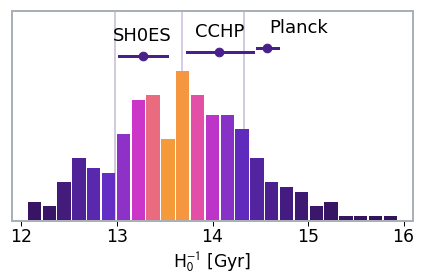

In [12]:
#%%script false
q = np.percentile(invH0, [16, 50, 84])
nbins = 25
n, bins, patches = plt.hist(invH0, bins=nbins, density=True, rwidth=0.901)
cm = plt.cm.get_cmap('phoenix')
plt.axvline(q[1], color=cm(0.20), alpha=0.3, zorder=0)
plt.axvline(q[0], color=cm(0.05), alpha=0.3, zorder=0)
plt.axvline(q[2], color=cm(0.05), alpha=0.3, zorder=0)
yl = plt.gca().get_ylim()

# # add measures
xmeasure = [planck, cchp, shoes]
ymeasure = [yl[-1]*1.1, yl[-1]*1.075, yl[-1]*1.05]
for x, y, c in zip(xmeasure, ymeasure, [cm(0.15), cm(0.15), cm(0.15)]):
    xshift = -1.5 if x.name == 'Planck' else 0
    x.plot(y, xshift=xshift, yshift=0.1*yl[-1], transform=H02Gyrs, msize=75, color=c)
# # as axvspans (monocolored/multicolored)
# for x in xmeasure:
#      x.span_multicolor(transform=H02Gyrs, cmap='phoenix', alpha=1., alpha_grad=True)

# add gaussian/lorentzian.voigt fits
bin_centers = 0.5 * (bins[:-1] + bins[1:])
dx = bin_centers[1]-bin_centers[0]
xdata = bin_centers  # [bin_centers[0]-i*dx for i in range(1, 16)] + list(bin_centers) + [bin_centers[-1]+i*dx for i in range(1, 16)]
ydata = n  # [0 for i in range(15)] + list(n) + [0 for i in range(15)]
lpopt, lpcov = curve_fit(lorentzian, xdata, ydata)
ldist = lorentzian(bin_centers, lpopt[0], lpopt[1], lpopt[2])
gpopt, gpcov = curve_fit(gaussian, xdata, ydata)
gdist = gaussian(bin_centers, gpopt[0], gpopt[1], gpopt[2])
vpopt, vpcov = curve_fit(pseudovoigt, xdata, ydata)
vdist = pseudovoigt(bin_centers, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
cpf = np.cumsum(n * abs(bins[0]-bins[-1]) / nbins) * 2
cpf[cpf > 1] = -(cpf[cpf > 1] - 1) + 1
for c, p in zip(cpf, patches):
    plt.setp(p, 'facecolor', cm(c))

# # add gaussian/lorentzian/voigt fits
# xdata = np.linspace(xdata[0], xdata[-1], 200)
# fit = lorentzian(xdata, lpopt[0], lpopt[1], lpopt[2])
# plt.plot(xdata, fit, color='black')
# fit = gaussian(xdata, gpopt[0], gpopt[1], gpopt[2])
# plt.plot(xdata, fit, color='black')
# vfit = pseudovoigt(xdata, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
# plt.plot(xdata, vfit, color='black')

# add text
plt.rcParams['mathtext.fontset'] = 'stixsans'
Hstr = 'H$_0^{{-1}}$ = ${:5.1f}^{{{:+4.1f}}}_{{{:+4.1f}}}$'
print(Hstr.format(q[1], np.diff(q)[1], -np.diff(q)[0]))
# plt.text(0.62, 0.85, Hstr.format(q[1], np.diff(q)[1], -np.diff(q)[0]), fontsize=19, color='black', transform=plt.gca().transAxes)

plt.gcf().axes[0].get_yaxis().set_visible(False)
plt.gca().set_xlim(bins[0]-dx, bins[-1]+dx)
plt.gca().set_ylim(0, yl[-1]*1.333)
# plt.gca().set_ylim(yl)
plt.xlabel('H$_0^{-1}$ [Gyr]')
plt.tight_layout()
plt.savefig('results/_invH0hist_{}_filter{}.pdf'.format(statefile.replace('.state', ''), lens), transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

$\rho_{\mathrm{c}}$ = $  5.4^{+0.6}_{-0.5}$


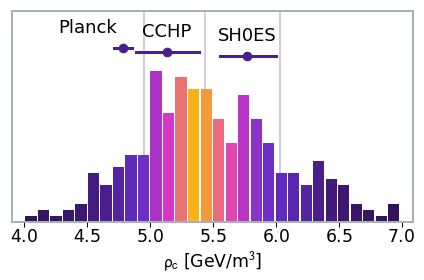

In [13]:
#%%script false
q = np.percentile(rhocrit, [16, 50, 84])
nbins = 30
n, bins, patches = plt.hist(rhocrit, bins=nbins, density=True, rwidth=0.901)
cm = plt.cm.get_cmap('phoenix')
plt.axvline(q[1], color=cm(0.20), alpha=0.3, zorder=0)
plt.axvline(q[0], color=cm(0.05), alpha=0.3, zorder=0)
plt.axvline(q[2], color=cm(0.05), alpha=0.3, zorder=0)
yl = plt.gca().get_ylim()

# add measures
xmeasure = [planck, cchp, shoes]
ymeasure = [yl[-1]*1.1, yl[-1]*1.075, yl[-1]*1.05]
for x, y, c in zip(xmeasure, ymeasure, [cm(0.15), cm(0.15), cm(0.15)]):
    xshift = -2 if x.name == 'Planck' else 0
    x.plot(y, xshift=xshift, yshift=0.1*yl[-1], transform=H02critdens, msize=75, color=c)
# # or as axvspans (multicolored)
# for x in xmeasure:
#      x.span_multicolor(transform=H02critdens, cmap='phoenix', alpha=1., alpha_grad=True)

# add gaussian/lorentzian/voigt color scheme to pdf
bin_centers = 0.5 * (bins[:-1] + bins[1:])
dx = bin_centers[1]-bin_centers[0]
xdata = [bin_centers[0]-i*dx for i in range(1, 16)] + list(bin_centers) + [bin_centers[-1]+i*dx for i in range(1, 16)]
ydata = [0 for i in range(15)] + list(n) + [0 for i in range(15)]
lpopt, lpcov = curve_fit(lorentzian, xdata, ydata)
ldist = lorentzian(bin_centers, lpopt[0], lpopt[1], lpopt[2])
gpopt, gpcov = curve_fit(gaussian, xdata, ydata)
gdist = gaussian(bin_centers, gpopt[0], gpopt[1], gpopt[2])
vpopt, vpcov = curve_fit(pseudovoigt, xdata, ydata)
vdist = pseudovoigt(bin_centers, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
cpf = np.cumsum(n * abs(bins[0]-bins[-1]) / nbins) * 2
cpf[cpf > 1] = -(cpf[cpf > 1] - 1) + 1
for c, p in zip(cpf, patches):
    plt.setp(p, 'facecolor', cm(c))

# # add gaussian/lorentzian/voigt fits
# xdata = np.linspace(xdata[0], xdata[-1], 200)
# lfit = lorentzian(xdata, lpopt[0], lpopt[1], lpopt[2])
# plt.plot(xdata, lfit, color='black')
# gfit = gaussian(xdata, gpopt[0], gpopt[1], gpopt[2])
# plt.plot(xdata, gfit, color='black')
# vfit = pseudovoigt(xdata, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
# plt.plot(xdata, vfit, color='black')

# add text
plt.rcParams['mathtext.fontset'] = 'stixsans'
Hstr = r"$\rho_{{\mathrm{{c}}}}$ = ${:5.1f}^{{{:+4.1f}}}_{{{:+4.1f}}}$"
print(Hstr.format(q[1], np.diff(q)[1], -np.diff(q)[0]))
# plt.text(0.02, 0.85, Hstr.format(q[1], np.diff(q)[1], -np.diff(q)[0]), fontsize=19, color='black', transform=plt.gca().transAxes)

plt.gcf().axes[0].get_yaxis().set_visible(False)
plt.gca().set_xlim(bins[0]-dx, bins[-1]+dx)
# plt.gca().set_ylim(yl)
plt.gca().set_ylim(0, yl[-1]*1.333)
plt.xlabel(r"$\rho_{\mathrm{c}}$ [GeV/m$^{{3}}$]")
plt.tight_layout()
plt.savefig('results/_H02denshist_{}_filter{}.pdf'.format(statefile.replace('.state', ''), lens), transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()


[0.0033333333333333266 0.00999999999999998   0.013333333333333336  0.01999999999999999   0.02999999999999997   0.05666666666666659   0.07666666666666672   0.10666666666666666   0.14333333333333326   0.17999999999999985   0.26333333333333303   0.3233333333333334    0.40333333333333327   0.47666666666666646   0.5500000000000003    0.6066666666666668    0.65                  0.7199999999999999    0.7766666666666664    0.8200000000000001    0.8466666666666667    0.8733333333333333    0.8933333333333334    0.9266666666666664    0.95                  0.9699999999999999    0.9799999999999999    0.9866666666666666    0.9899999999999999    0.9999999999999999   ]


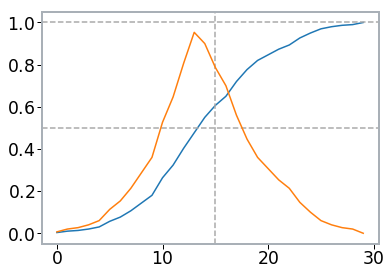

In [14]:
cpf = np.cumsum(n * abs(bins[0]-bins[-1]) / nbins)
print(cpf)
plt.plot(cpf)
plt.axhline(1, ls='--', color='darkgrey')
plt.axhline(0.5, ls='--', color='darkgrey')
plt.axvline(0.5*nbins, ls='--', color='darkgrey')
cpf = 2*cpf
cpf[cpf > 1] = -(cpf[cpf > 1] - 1) + 1
plt.plot(cpf)
